Modeling the Worst: A Zombie and Ebola outbreak

MOD300: Mandatory Project 2

Collaborators:  

Abstract

Introduction

#Modeling a Zombie Outbreak - SZ Model

**Aim.** Develop and document the two-compartment SZ model used in the project:
susceptibles S(t) and zombies Z(t). Provide (i) assumptions, (ii) derivation of the ODEs,
(iii) interpretation of β, (iv) the closed-form (analytic) solution, and (v) a short
sanity-check plot. This section is self-contained and stops before Exercise 1.

**Context.** The project specifies a minimal two-compartment model with only one flow:
S → Z. No curing or removal is included here. The population is assumed well-mixed
(mass-action).


#### 1) Model and Assumptions

**Compartments.** $S(t)$: susceptible humans; $Z(t)$: zombies. Only $S\to Z$ transport is allowed
(once bitten/scratched, you are a zombie). The compartments are assumed *well mixed*, i.e.,
pairs of individuals interact with equal probability.

**Contact model and infection probability.** Let $C(N)$ be the per-person contact rate
(contacts per unit time). At time $t$ the probability that a random contact is with a zombie
is $Z(t)/N$. Let $p_Z$ be the probability that an $S$–$Z$ encounter causes infection. Then define
the transmission parameter

$$
\beta \;=\; p_Z \cdot C(N) \quad \text{(units: time}^{-1}\text{).}
$$

Over a small interval $\Delta t$, the expected reduction in $S$ is
$$
S(t+\Delta t) - S(t) \;=\; -\,\beta\,\Delta t\,\frac{Z(t)}{N}\,S(t). \tag{1}
$$

**Constant population.** In this base model, $N = S(t) + Z(t)$ is treated as constant
(ignoring births/deaths/migration). Taking $\Delta t \to 0$ gives the ODE system
$$
\frac{dS}{dt} \;=\; -\beta \,\frac{S Z}{N},
\qquad
\frac{dZ}{dt} \;=\; \beta \,\frac{S Z}{N}. \tag{2–3}
$$

We assume $Z(0)=Z_0\ge 1$ (typically $Z_0=1$).



#### 2) Interpretation of $\beta$ — Technical and Intuitive Views

**Technical.** $\beta$ bundles (i) how often people meet ($C$) and (ii) how risky each $S$–$Z$
contact is ($p_Z$). The mass-action term $S\cdot Z/N$ encodes well-mixed interactions.
Equation (1) becomes (2–3) by dividing by $\Delta t$ and letting $\Delta t\to 0$.

**Intuition.** $\beta$ is a single “speed knob” for spread: more meetings and/or higher bite
risk $\Rightarrow$ faster conversion of $S$ to $Z$.


#### 3) Analytic (Closed-Form) Solution

With $S_0=S(0)$, $Z_0=Z(0)$, and $N=S_0+Z_0$, the SZ system (2–3) has the exact solution
$$
S(t)=\frac{(S_0+Z_0)\,(S_0/Z_0)\,e^{-\beta t}}{1+(S_0/Z_0)\,e^{-\beta t}},
\qquad
Z(t)=\frac{S_0+Z_0}{1+(S_0/Z_0)\,e^{-\beta t}}. \tag{4–5}
$$

These expressions conserve $S(t)+Z(t)=N$ for all $t$.

*Remark.* Using $S=N-Z$, (3) becomes $\,\dfrac{dZ}{dt}=\dfrac{\beta}{N}\,Z\,(N-Z)$, i.e., **logistic
growth** toward the carrying capacity $N$ when $\beta>0$ and $Z_0>0$ (formal fixed-point
analysis is left for Exercise 1).



#### 4) Parameter Example from the Project

A scenario in the project estimates $\beta$ with 10 hours of contact, a 20% infection chance
for the family, and one zombie among three persons ($Z/N=1/3$). Using
$$
\beta \cdot (Z/N) \cdot \Delta t \;=\; 0.20
\;\Rightarrow\;
\beta \cdot \frac{1}{3} \cdot 10\,\text{h} \;=\; 0.20
\;\Rightarrow\;
\beta \;=\; 0.06\ \text{h}^{-1}.
$$

We reuse $\beta=0.06\ \text{h}^{-1}$ in the demo below.


#### 5) Implementation (Utilities for Reuse Later)

We provide: (i) `beta_from_contacts` to compute $\beta = p_{\text{infect}}\cdot\text{contact\_rate}$,
(ii) `analytic_sz` to evaluate the exact solution at arbitrary times, and (iii) a
conservation checker for $S+Z=N$. These will be reused to validate numerical solvers
in later parts of the project.


In [18]:
#%% 
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

def beta_from_contacts(p_infect: float, contacts_per_person_per_time: float) -> float:
    """
    Compute β = p_infect * contacts_per_person_per_time.

    Parameters
    ----------
    p_infect : float
        Probability that an S–Z encounter infects the human (0..1).
    contacts_per_person_per_time : float
        Average per-person contact rate (per unit time).

    Returns
    -------
    float
        β in 1/time units.
    """
    return p_infect * contacts_per_person_per_time


def analytic_sz(t: np.ndarray, S0: float, Z0: float, beta: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Closed-form (analytic) SZ solution.

    Parameters
    ----------
    t : array-like
        Time points for evaluation.
    S0 : float
        Initial susceptible count at t=0.
    Z0 : float
        Initial zombie count at t=0 (>= 1 for nontrivial dynamics).
    beta : float
        Transmission parameter (1/time).

    Returns
    -------
    (S, Z) : tuple of np.ndarray
        Arrays of S(t) and Z(t) at the requested times.

    Notes
    -----
    Implements equations (4)–(5) with N = S0 + Z0.
    """
    t = np.asarray(t, dtype=float)
    N = S0 + Z0
    ratio = (S0 / Z0) * np.exp(-beta * t)
    denom = (1.0 + ratio)
    S = (N * (S0 / Z0) * np.exp(-beta * t)) / denom
    Z = N / denom
    return S, Z


def check_conservation(S: np.ndarray, Z: np.ndarray, N: float, atol: float = 1e-10) -> bool:
    """Return True if S+Z == N within the given tolerance."""
    return np.allclose(S + Z, N, atol=atol)


#### 6) Sanity-Check Demo (Not Exercise 1)

We take $N=1000$, $Z_0=1$, $S_0=999$, and $\beta=0.06\ \text{h}^{-1}$ (from the scenario),
evaluate the analytic solution on $[0,200]$ hours, verify conservation, and plot fractions
$S/N$ and $Z/N$. This is *only* to visualize the model’s qualitative behavior; Exercise 1
will use the same formulas to compare Sokndal and Dirdal explicitly.


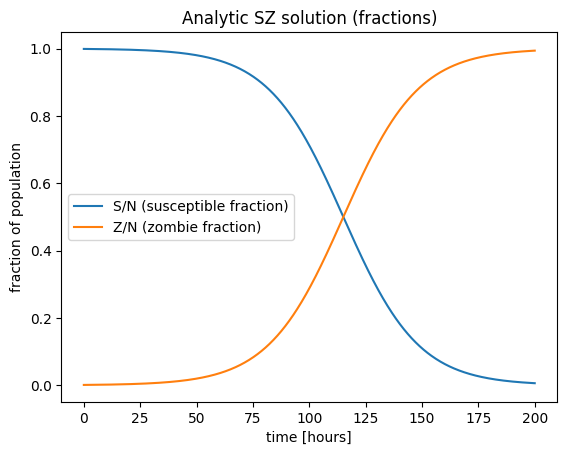

In [19]:
#%% 
# Parameters
N = 1000.0
Z0 = 1.0
S0 = N - Z0
beta = 0.06  # h^-1 (from the scenario)

# Time grid (hours)
t = np.linspace(0.0, 200.0, 800)

# Analytic solution
S, Z = analytic_sz(t, S0, Z0, beta)

# Conservation check
assert check_conservation(S, Z, N), "Conservation failed: S+Z != N"

# (Optional) monotonicity sanity check for β>0, Z0>0:
dS = np.diff(S)
dZ = np.diff(Z)
assert (dS <= 1e-12).all(), "S(t) should be non-increasing for β>0, Z0>0"
assert (dZ >= -1e-12).all(), "Z(t) should be non-decreasing for β>0, Z0>0"

# Plot fractions
plt.figure()
plt.plot(t, S / N, label="S/N (susceptible fraction)")
plt.plot(t, Z / N, label="Z/N (zombie fraction)")
plt.xlabel("time [hours]")
plt.ylabel("fraction of population")
plt.title("Analytic SZ solution (fractions)")
plt.legend()
plt.show()



## 7) Summary of the SZ Section

- The base model assumes well-mixed interactions and a single S→Z flow; \(N=S+Z\) is constant.
- The governing equations are \(dS/dt = -\beta S Z / N\) and \(dZ/dt = \beta S Z / N\), with \(\beta=p_Z\cdot C(N)\).
- The analytic solution (4–5) conserves population and is ideal for validating numerical solvers.
- A project-provided scenario gives \(\beta = 0.06\ \text{h}^{-1}\); we used it for a minimal sanity check.

**Next step (Exercise 1, not done here):** use (4–5) to compare zombie fractions for Sokndal (N=3305)
and Dirdal (N=683), and analyze critical points/logistic limit behavior for \(\beta>0\).


Exercise 1

Exercise 2

Exercise 3

Exercise 4

Exercise 5

Reflection